In [1]:
'''Pre-train the ViT-MAE from scratch on CIFAR-10.
First successful attempt.'''

'Pre-train the ViT-MAE from scratch on CIFAR-10.\nFirst attempt.'

In [2]:
import argparse
import datetime
import json
import numpy as np
import os
import time
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import timm
import timm.optim.optim_factory as optim_factory

2023-08-11 08:00:50.428306: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 08:00:51.047187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Some functions from the misc file
#import torch.distributed as dist
#from torch._six import inf
from math import inf
from pathlib import Path
import torch


#----------------------------------------
# Metric logger and SmoothedValue classed modded for single GPU training
import time
from collections import defaultdict, deque
import datetime


class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if v is None:
                continue
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        log_msg = [
            header,
            '[{0' + space_fmt + '}/{1}]',
            'eta: {eta}',
            '{meters}',
            'time: {time}',
            'data: {data}'
        ]
        if torch.cuda.is_available():
            log_msg.append('max mem: {memory:.0f}')
        log_msg = self.delimiter.join(log_msg)
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))



#-----------------------------------------



class NativeScalerWithGradNormCount:
    state_dict_key = "amp_scaler"

    def __init__(self):
        self._scaler = torch.cuda.amp.GradScaler()

    def __call__(self, loss, optimizer, clip_grad=None, parameters=None, create_graph=False, update_grad=True):
        self._scaler.scale(loss).backward(create_graph=create_graph)
        if update_grad:
            if clip_grad is not None:
                assert parameters is not None
                self._scaler.unscale_(optimizer)  # unscale the gradients of optimizer's assigned params in-place
                norm = torch.nn.utils.clip_grad_norm_(parameters, clip_grad)
            else:
                self._scaler.unscale_(optimizer)
                norm = get_grad_norm_(parameters)
            self._scaler.step(optimizer)
            self._scaler.update()
        else:
            norm = None
        return norm

    def state_dict(self):
        return self._scaler.state_dict()

    def load_state_dict(self, state_dict):
        self._scaler.load_state_dict(state_dict)


def get_grad_norm_(parameters, norm_type: float = 2.0) -> torch.Tensor:
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    norm_type = float(norm_type)
    if len(parameters) == 0:
        return torch.tensor(0.)
    device = parameters[0].grad.device
    if norm_type == inf:
        total_norm = max(p.grad.detach().abs().max().to(device) for p in parameters)
    else:
        total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach(), norm_type).to(device) for p in parameters]), norm_type)
    return total_norm


def save_model(args, epoch, model, model_without_ddp, optimizer, loss_scaler):
    output_dir = Path(args['output_dir'])
    epoch_name = str(epoch)
    
    if loss_scaler is not None:
        checkpoint_path = output_dir / ('checkpoint-%s.pth' % epoch_name)
        to_save = {
            'model': model_without_ddp.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'scaler': loss_scaler.state_dict(),
            'args': args,
        }
        torch.save(to_save, checkpoint_path)
    else:
        client_state = {'epoch': epoch}
        model.save_checkpoint(save_dir=args['output_dir'], tag="checkpoint-%s" % epoch_name, client_state=client_state)


def load_model(args, model_without_ddp, optimizer, loss_scaler):
    # Check if 'resume' exists in args and if it's not None/empty
    if args['resume']:
        # Download checkpoint from URL if it starts with 'https'
        if args['resume'].startswith('https'):
            checkpoint = torch.hub.load_state_dict_from_url(
                args['resume'], map_location='cpu', check_hash=True)
        else: # Otherwise, load it from local path
            checkpoint = torch.load(args['resume'], map_location='cpu')
        # Load the model state from checkpoint
        model_without_ddp.load_state_dict(checkpoint['model'])
        print("Resume checkpoint %s" % args['resume'])
        # Check if checkpoint has optimizer and epoch details, and args doesn't have 'eval' set to True
        if 'optimizer' in checkpoint and 'epoch' in checkpoint and not args.get('eval'): #('eval' in args and args['eval']):
            optimizer.load_state_dict(checkpoint['optimizer'])
            args['start_epoch'] = checkpoint['epoch'] + 1
            if 'scaler' in checkpoint:
                loss_scaler.load_state_dict(checkpoint['scaler'])
            print("With optim & sched!")



In [4]:
import math
import sys
from typing import Iterable

#import torch
#import util.misc as misc
#import util.lr_sched as lr_sched
#import math

# Function from lr_sched.py
def adjust_learning_rate(optimizer, epoch, args):
    """Decay the learning rate with half-cycle cosine after warmup"""
    if epoch < args['warmup_epochs']:
        lr = args['lr'] * epoch / args['warmup_epochs'] 
    else:
        lr = args['min_lr'] + (args['lr'] - args['min_lr']) * 0.5 * \
            (1. + math.cos(math.pi * (epoch - args['warmup_epochs']) / (args['epochs'] - args['warmup_epochs'])))
    for param_group in optimizer.param_groups:
        if "lr_scale" in param_group:
            param_group["lr"] = lr * param_group["lr_scale"]
        else:
            param_group["lr"] = lr
    return lr


# def train_one_epoch(model: torch.nn.Module,
#                     data_loader: Iterable, optimizer: torch.optim.Optimizer,
#                     device: torch.device, epoch: int, loss_scaler,
#                     log_writer=None,
#                     args=None):
#     model.train(True)

In [5]:
# import math
# import sys
# from typing import Iterable

# import torch
# import util.misc as misc
# import util.lr_sched as lr_sched


def train_one_epoch(model: torch.nn.Module,
                    data_loader: Iterable, optimizer: torch.optim.Optimizer,
                    device: torch.device, epoch: int, loss_scaler,
                    log_writer=None,
                    args=None):
    model.train(True)
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)
    print_freq = 20

    accum_iter = args['accum_iter']

    optimizer.zero_grad()

    if log_writer is not None:
        print('log_dir: {}'.format(log_writer.log_dir))

    for data_iter_step, (samples, _) in enumerate(metric_logger.log_every(data_loader, print_freq, header)):

        # we use a per iteration (instead of per epoch) lr scheduler
        if data_iter_step % accum_iter == 0:
            adjust_learning_rate(optimizer, data_iter_step / len(data_loader) + epoch, args)

        samples = samples.to(device, non_blocking=True)

        with torch.cuda.amp.autocast():
            loss, _, _ = model(samples, mask_ratio=args['mask_ratio'])

        loss_value = loss.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        loss /= accum_iter
        loss_scaler(loss, optimizer, parameters=model.parameters(),
                    update_grad=(data_iter_step + 1) % accum_iter == 0)
        if (data_iter_step + 1) % accum_iter == 0:
            optimizer.zero_grad()

        metric_logger.update(loss=loss_value)

        lr = optimizer.param_groups[0]["lr"]
        metric_logger.update(lr=lr)

        if log_writer is not None and (data_iter_step + 1) % accum_iter == 0:
            epoch_1000x = int((data_iter_step / len(data_loader) + epoch) * 1000)
            log_writer.add_scalar('train_loss', loss_value, epoch_1000x)
            log_writer.add_scalar('lr', lr, epoch_1000x)

    print("Stats:", metric_logger)
    return {k: meter.avg for k, meter in metric_logger.meters.items()}


In [6]:
import datetime
import json
import numpy as np
import os
import time
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import timm
import timm.optim.optim_factory as optim_factory

In [7]:
# Configurations as dictionary
args = {
    'batch_size': 64, #8, #16, #32, #64,
    'epochs': 400,
    'accum_iter': 1,
    'model': 'mae_vit_base_patch16', #'mae_vit_large_patch16',
    'input_size': 224,
    'mask_ratio': 0.75,
    'norm_pix_loss': False,
    'weight_decay': 0.05,
    'lr': None,
    'blr': 1e-3,
    'min_lr': 0.0,
    'warmup_epochs': 40,
    'data_path': 'data',
    'output_dir': 'models/vitmae_cifar10',
    'log_dir': 'models',
    'device': 'cuda:0',
    'seed': 42,
    'resume': '',
    'start_epoch': 0,
    'num_workers': 10,
    'pin_mem': True
}

In [8]:
print("{}".format(args).replace(', ', ',\n'))

{'batch_size': 64,
'epochs': 400,
'accum_iter': 1,
'model': 'mae_vit_base_patch16',
'input_size': 224,
'mask_ratio': 0.75,
'norm_pix_loss': False,
'weight_decay': 0.05,
'lr': None,
'blr': 0.001,
'min_lr': 0.0,
'warmup_epochs': 40,
'data_path': 'data',
'output_dir': 'models',
'log_dir': 'models',
'device': 'cuda:0',
'seed': 42,
'resume': '',
'start_epoch': 0,
'num_workers': 10,
'pin_mem': True}


In [9]:
device = torch.device(args['device'])
print(device)



cudnn.benchmark = True

cuda:0


In [10]:
# Vit-MAE model

from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    # omega = np.arange(embed_dim // 2, dtype=np.float) # causes error in pytorch 2.0; replacing with below line:
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask


def mae_vit_base_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def mae_vit_large_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def mae_vit_huge_patch14_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=14, embed_dim=1280, depth=32, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


# set recommended archs
mae_vit_base_patch16 = mae_vit_base_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_large_patch16 = mae_vit_large_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_huge_patch14 = mae_vit_huge_patch14_dec512d8b  # decoder: 512 dim, 8 blocks



/tmp/ipykernel_40102/3873979130.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Files already downloaded and verified


<Figure size 640x480 with 0 Axes>

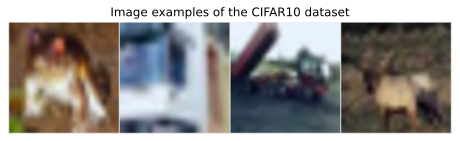

In [11]:
## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

## Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# fix the seed for reproducibility
seed = args['seed']
torch.manual_seed(seed)
np.random.seed(seed)


transform_train = transforms.Compose([
            transforms.RandomResizedCrop(args['input_size'], scale=(0.2, 1.0), interpolation=3),  # 3 is bicubic
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset_train = CIFAR10(root=args['data_path'], train=True, transform=transform_train, download=True)
sampler_train = torch.utils.data.RandomSampler(dataset_train)

log_writer = SummaryWriter(log_dir=args['log_dir'])
#pl.seed_everything(args['seed'])


data_loader_train = data.DataLoader(
        dataset_train, sampler=sampler_train,
        batch_size=args['batch_size'],
        num_workers=args['num_workers'],
        pin_memory=args['pin_mem'],
        drop_last=True,
    )
    

# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack([dataset_train[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [12]:
# Load the model...
 # Initialize the model
if args['model'] == "mae_vit_base_patch16":
    model = mae_vit_base_patch16(norm_pix_loss=args['norm_pix_loss'])
elif args['model'] == "mae_vit_large_patch16":
    model = mae_vit_large_patch16(norm_pix_loss=args['norm_pix_loss'])
elif args['model'] == "mae_vit_huge_patch14":
    model = mae_vit_huge_patch14(norm_pix_loss=args['norm_pix_loss'])
else:
    raise ValueError(f"Unsupported model name: {args['model']}")

model.to(device)

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (decoder_embed): Linear(in_features=768, out_features=512, bias=

In [13]:
print(model.blocks)

ModuleList(
  (0-11): 12 x Block(
    (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (attn): Attention(
      (qkv): Linear(in_features=768, out_features=2304, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=768, out_features=768, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
    )
    (drop_path): Identity()
    (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (act): GELU(approximate='none')
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
  )
)


In [14]:
def print_full_module(module, indent=0):
    print('  ' * indent + module._get_name() + '(')
    for name, child in module.named_children():
        print('  ' * (indent + 1) + '(' + name + '):', end=' ')
        print_full_module(child, indent + 2)
    print('  ' * indent + ')')

print_full_module(model)


MaskedAutoencoderViT(
  (patch_embed):     PatchEmbed(
      (proj):         Conv2d(
        )
    )
  (blocks):     ModuleList(
      (0):         Block(
          (norm1):             LayerNorm(
            )
          (attn):             Attention(
              (qkv):                 Linear(
                )
              (attn_drop):                 Dropout(
                )
              (proj):                 Linear(
                )
              (proj_drop):                 Dropout(
                )
            )
          (drop_path):             Identity(
            )
          (norm2):             LayerNorm(
            )
          (mlp):             Mlp(
              (fc1):                 Linear(
                )
              (act):                 GELU(
                )
              (fc2):                 Linear(
                )
              (drop):                 Dropout(
                )
            )
        )
      (1):         Block(
          (norm1

In [15]:
eff_batch_size = args['batch_size'] * args['accum_iter']

if args['lr'] is None:  # only base_lr is specified
    args['lr'] = args['blr'] * eff_batch_size / 256

param_groups = optim_factory.add_weight_decay(model, args['weight_decay'])
optimizer = torch.optim.AdamW(param_groups, lr=args['lr'], betas=(0.9, 0.95))
loss_scaler = NativeScalerWithGradNormCount()

load_model(args=args, model_without_ddp=model, optimizer=optimizer, loss_scaler=loss_scaler)



In [16]:
print(f"Start training for {args['epochs']} epochs")
start_time = time.time()
for epoch in range(args['start_epoch'], args['epochs']):
    train_stats = train_one_epoch(
        model, data_loader_train,
        optimizer, device, epoch, loss_scaler,
        log_writer=log_writer,
        args=args
    )
    if args['output_dir'] and (epoch % 20 == 0 or epoch + 1 == args['epochs']):
        save_model(
            args=args, model=model, model_without_ddp=model, optimizer=optimizer,
            loss_scaler=loss_scaler, epoch=epoch)

    log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                    'epoch': epoch, }

    if args['output_dir']:
        if log_writer is not None:
            log_writer.flush()
        with open(os.path.join(args['output_dir'], "log.txt"), mode="a", encoding="utf-8") as f:
            f.write(json.dumps(log_stats) + "\n")

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))

Start training for 400 epochs
log_dir: models
Epoch: [0]  [  0/781]  eta: 0:40:47  lr: 0.000000  loss: 1.8352 (1.8352)  time: 3.1338  data: 1.4109  max mem: 5840
Epoch: [0]  [ 20/781]  eta: 0:05:49  lr: 0.000000  loss: 1.9714 (1.9637)  time: 0.3261  data: 0.0001  max mem: 6707
Epoch: [0]  [ 40/781]  eta: 0:04:53  lr: 0.000000  loss: 1.8681 (1.9304)  time: 0.3278  data: 0.0001  max mem: 6707
Epoch: [0]  [ 60/781]  eta: 0:04:28  lr: 0.000000  loss: 1.8423 (1.9071)  time: 0.3270  data: 0.0001  max mem: 6707
Epoch: [0]  [ 80/781]  eta: 0:04:13  lr: 0.000001  loss: 1.7142 (1.8631)  time: 0.3281  data: 0.0001  max mem: 6707
Epoch: [0]  [100/781]  eta: 0:04:02  lr: 0.000001  loss: 1.6169 (1.8155)  time: 0.3291  data: 0.0001  max mem: 6707
Epoch: [0]  [120/781]  eta: 0:03:52  lr: 0.000001  loss: 1.5203 (1.7684)  time: 0.3297  data: 0.0001  max mem: 6707
Epoch: [0]  [140/781]  eta: 0:03:43  lr: 0.000001  loss: 1.3972 (1.7182)  time: 0.3305  data: 0.0001  max mem: 6707
Epoch: [0]  [160/781]  eta

AttributeError: 'dict' object has no attribute 'epochs'